In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from IPython.display import Math, display
import numpy as np
import sympy as sp
from scipy import constants as const
from scipy.optimize import minimize_scalar, curve_fit
from scipy import sparse
import qutip as qt

#add relative path to backend
import sys
sys.path.append('../../clean_diag/backend')

import trap_units as si
from twod_trap import DoubleTweezer, TwoSiteLattice
from boson_helpers import *

# Choose data to analyse

In [6]:
start_line = 292
end_line = 332

n_lines = end_line - start_line + 1
lines = np.arange(start_line,end_line+1,dtype=int)
state_nrs = np.zeros((n_lines,2),dtype=int)
state_nrs[:,1] = 1

state_nrs[9,1] = 2
state_nrs[18,1] = 2
state_nrs[26,1] = 2

degeneracy = np.full(n_lines, True, dtype=bool)

------------------

line: 292
separation: 1.5472 um


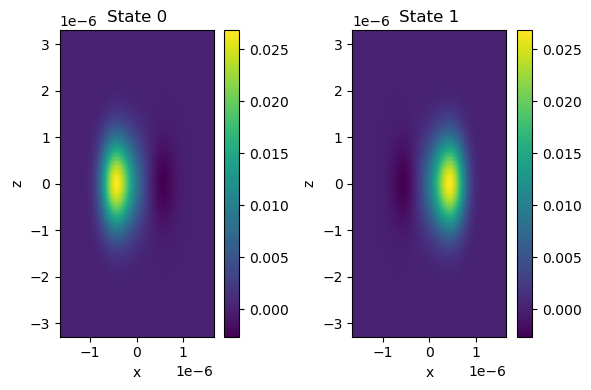

line: 293
separation: 1.5597 um


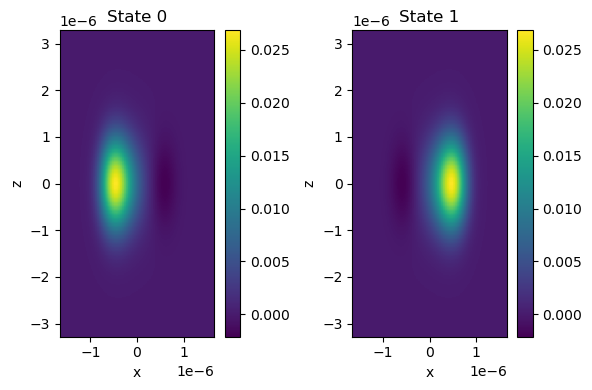

line: 294
separation: 1.5722 um


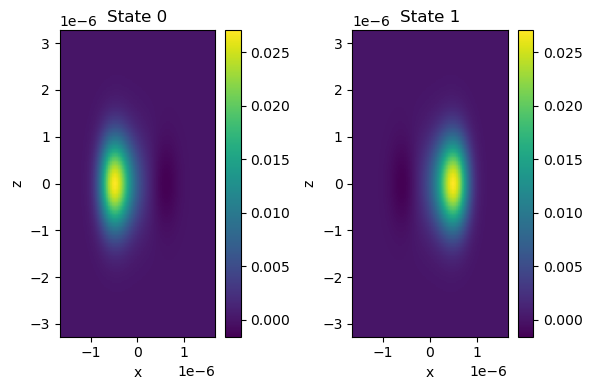

line: 295
separation: 1.5847 um


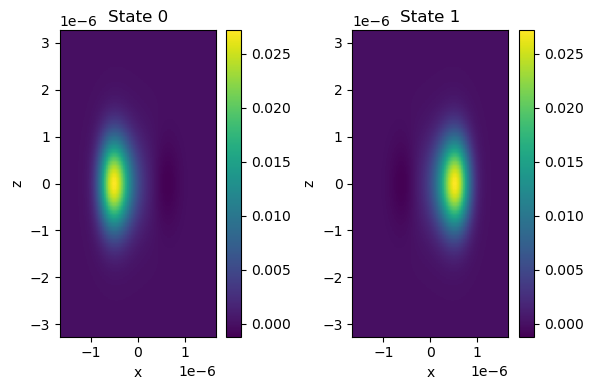

line: 296
separation: 1.5972 um


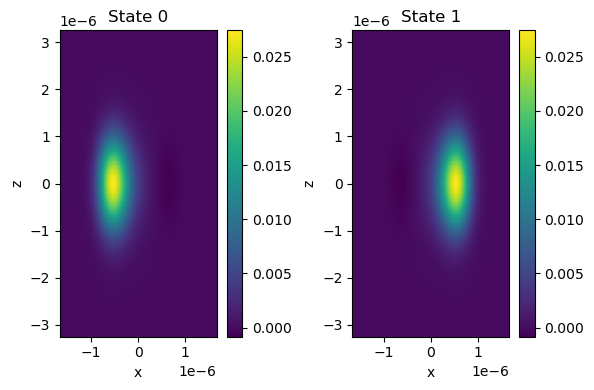

line: 297
separation: 1.6097 um


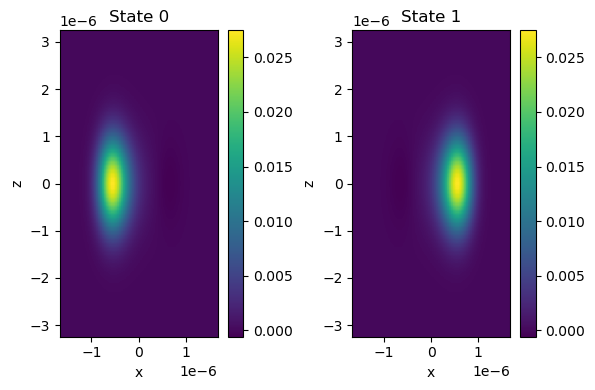

line: 298
separation: 1.6222 um


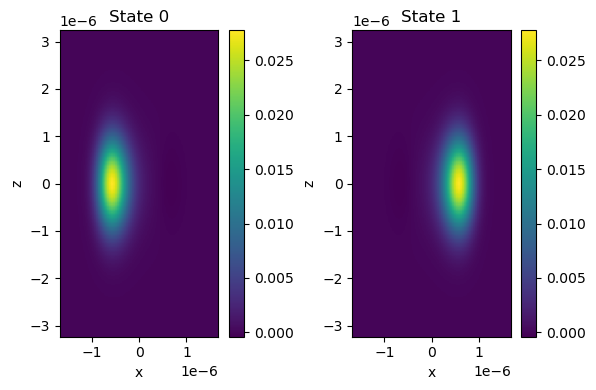

line: 299
separation: 1.6347 um


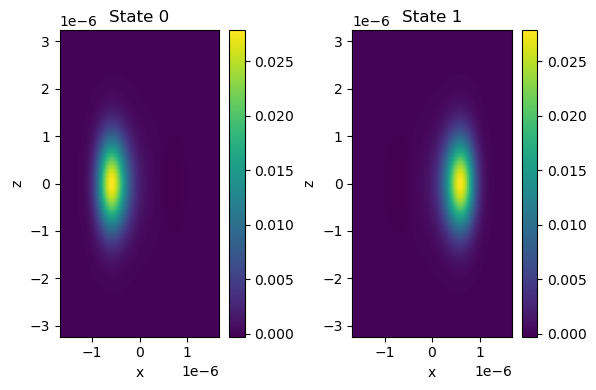

line: 300
separation: 1.6472 um


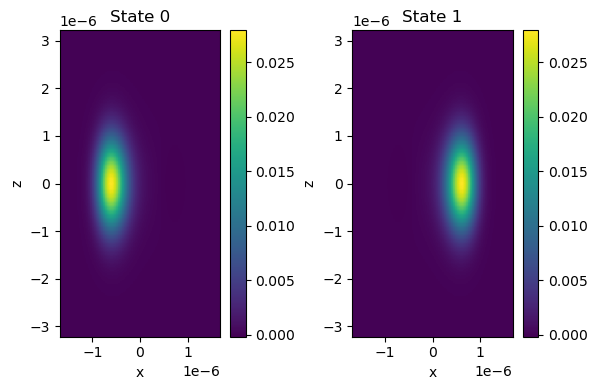

line: 301
separation: 1.4370 um


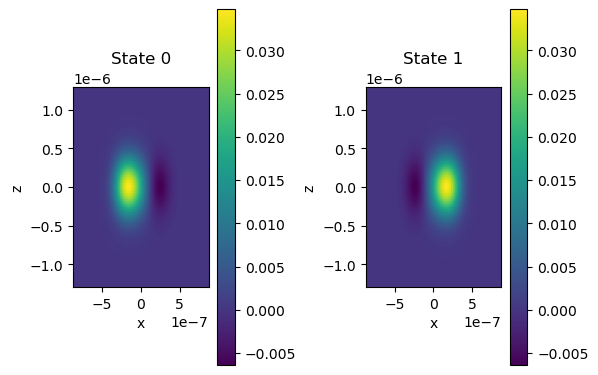

line: 302
separation: 1.4495 um


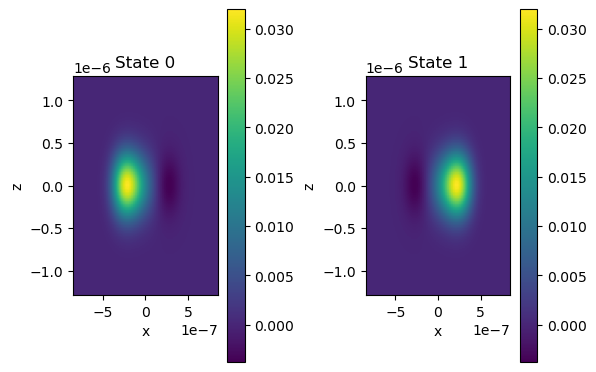

line: 303
separation: 1.4620 um


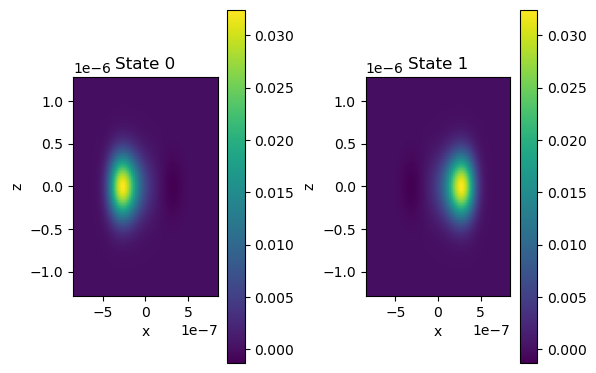

line: 304
separation: 1.4745 um


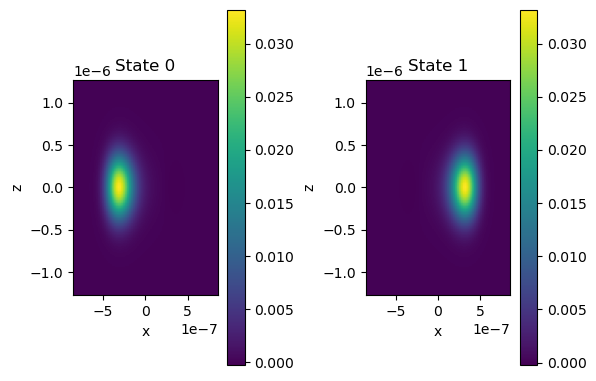

line: 305
separation: 1.4870 um


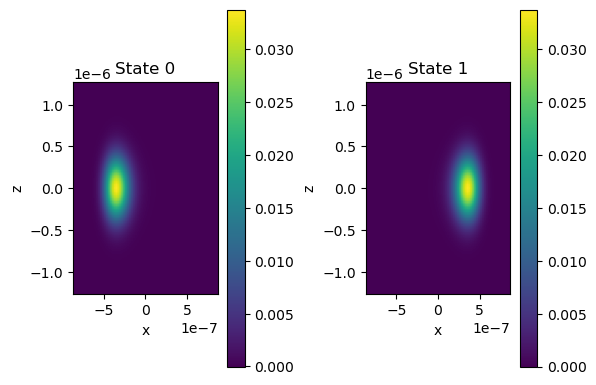

line: 306
separation: 1.4995 um


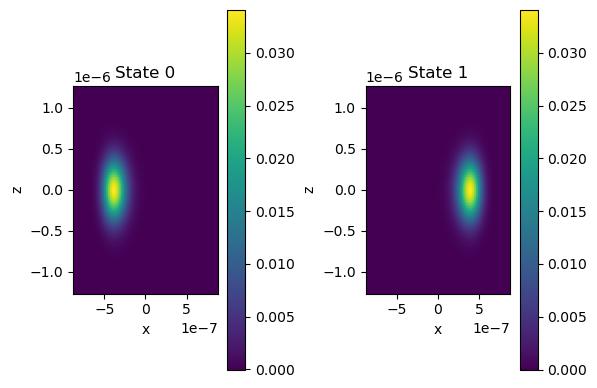

line: 307
separation: 1.5120 um


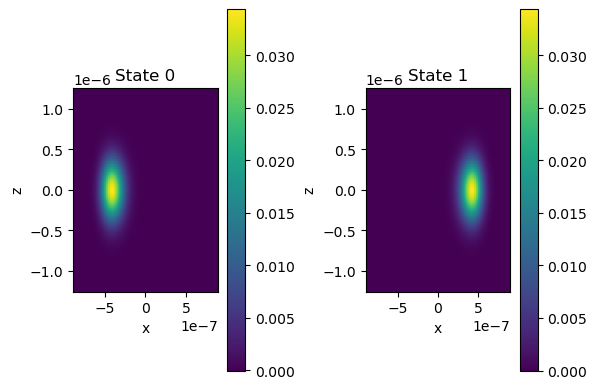

line: 308
separation: 1.5245 um


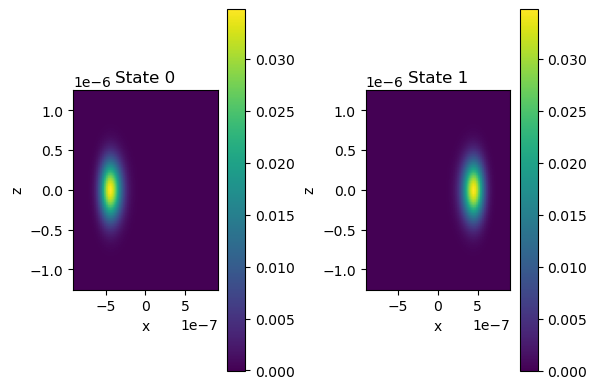

line: 309
separation: 1.5370 um


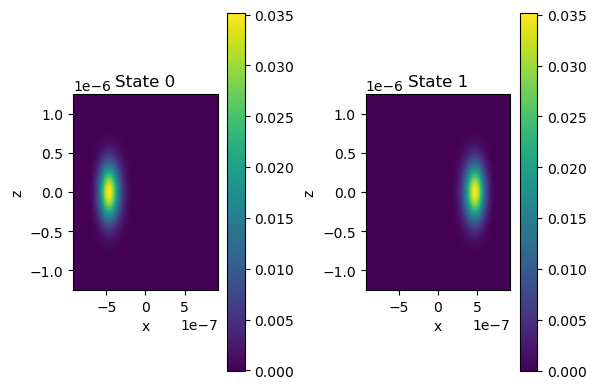

line: 310
separation: 1.4316 um


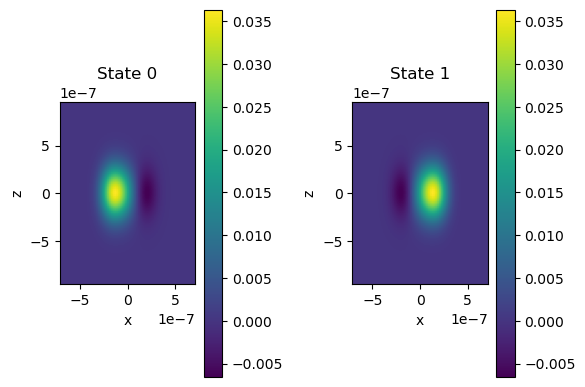

line: 311
separation: 1.4441 um


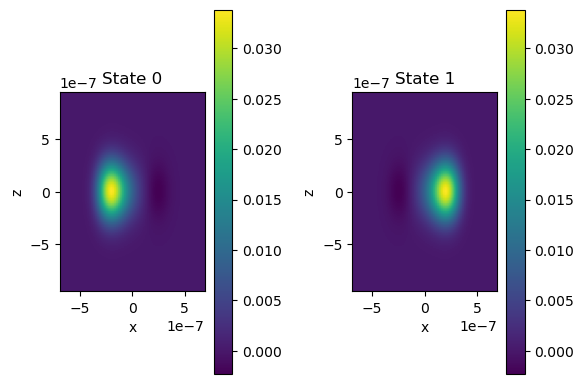

line: 312
separation: 1.4566 um


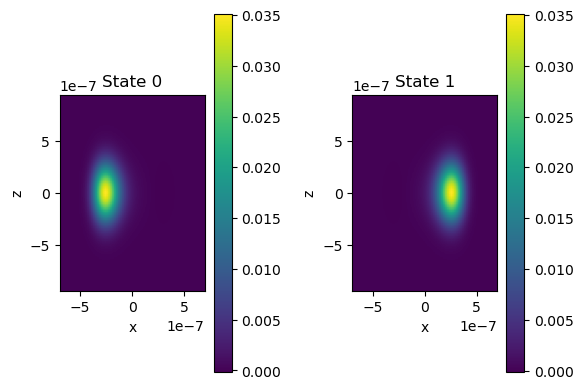

line: 313
separation: 1.4691 um


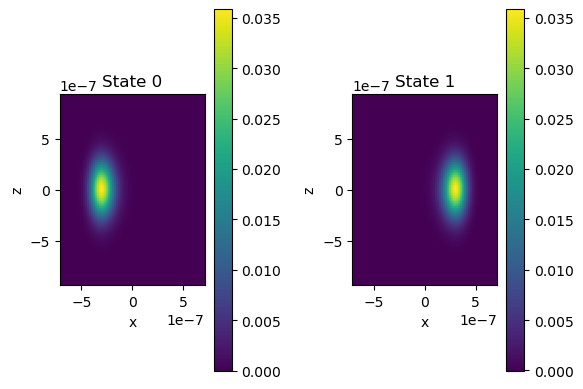

line: 314
separation: 1.4816 um


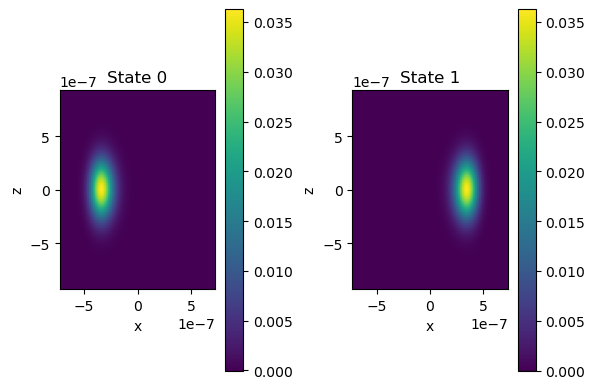

line: 315
separation: 1.4941 um


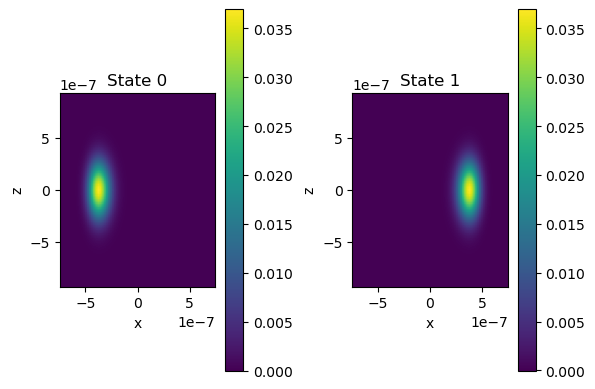

line: 316
separation: 1.5066 um


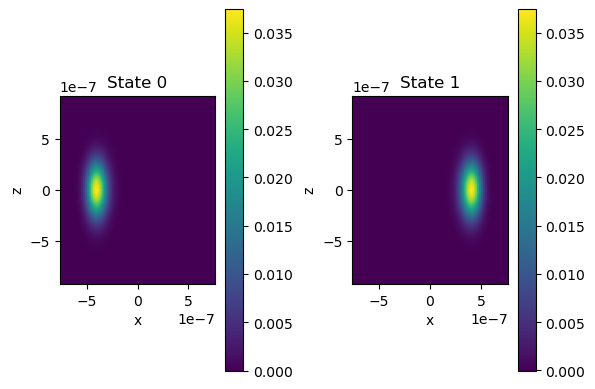

line: 317
separation: 1.5191 um


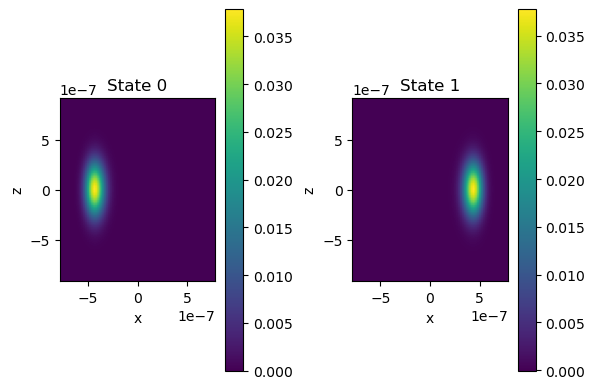

line: 318
separation: 1.4231 um


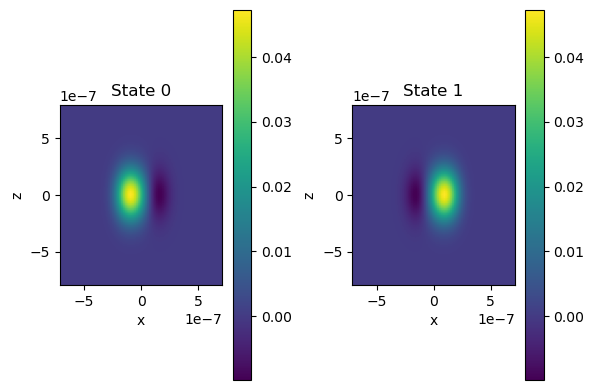

line: 319
separation: 1.4356 um


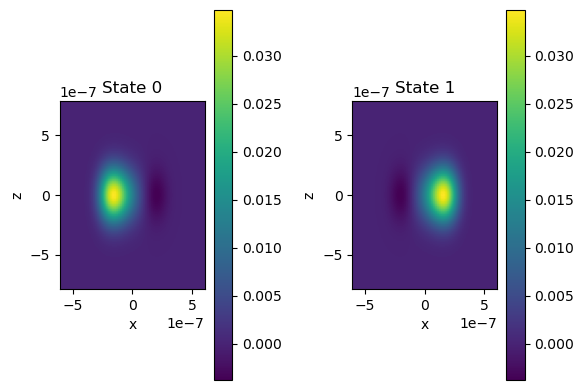

line: 320
separation: 1.4481 um


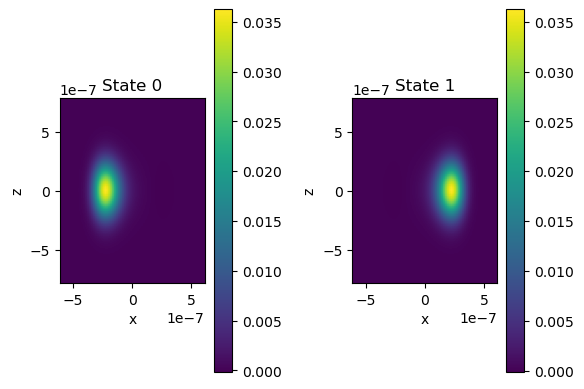

line: 321
separation: 1.4606 um


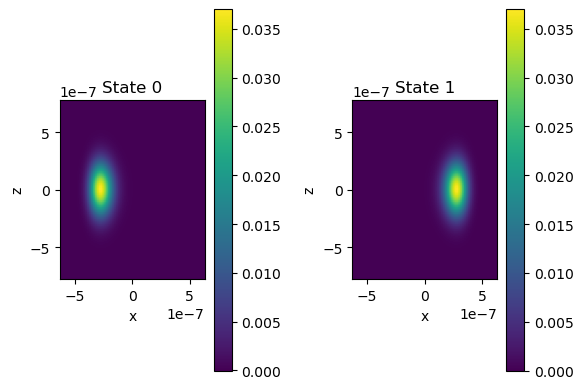

line: 322
separation: 1.4731 um


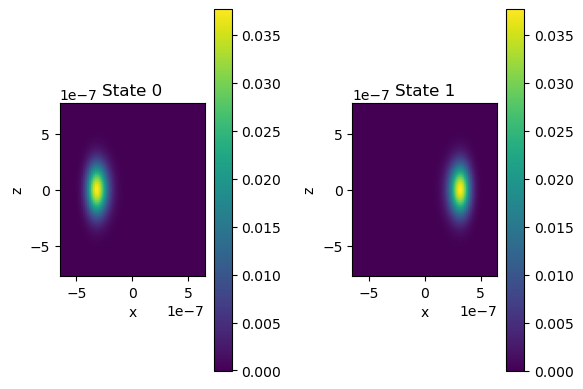

line: 323
separation: 1.4856 um


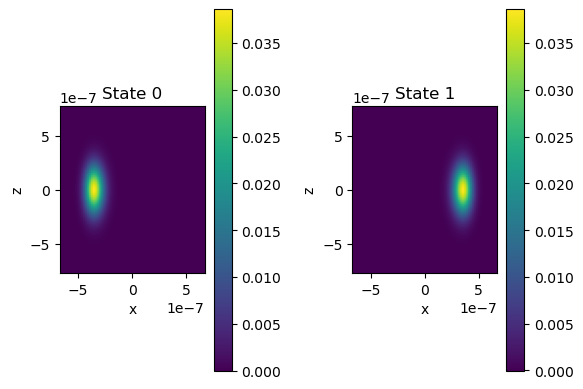

line: 324
separation: 1.4981 um


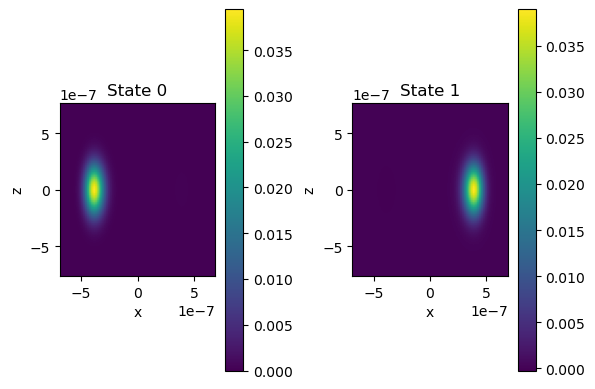

line: 325
separation: 1.5106 um


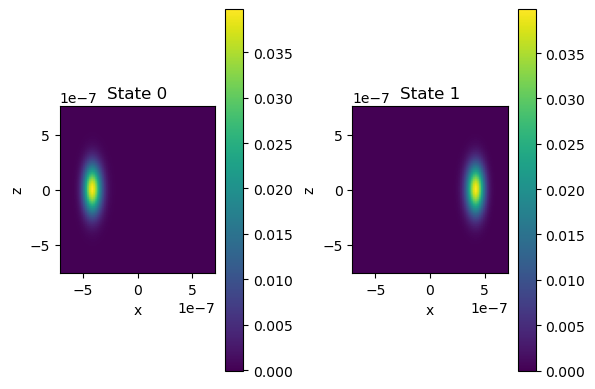

line: 326
separation: 1.4304 um


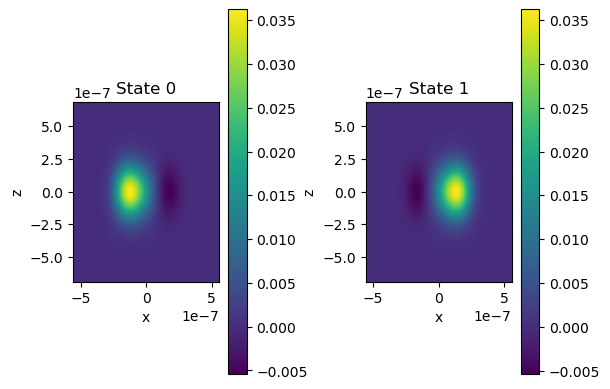

line: 327
separation: 1.4429 um


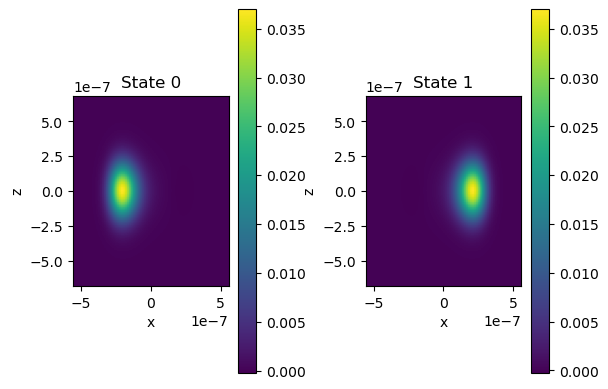

line: 328
separation: 1.4554 um


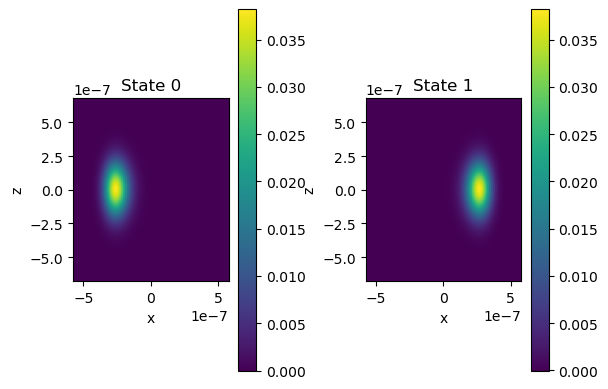

line: 329
separation: 1.4679 um


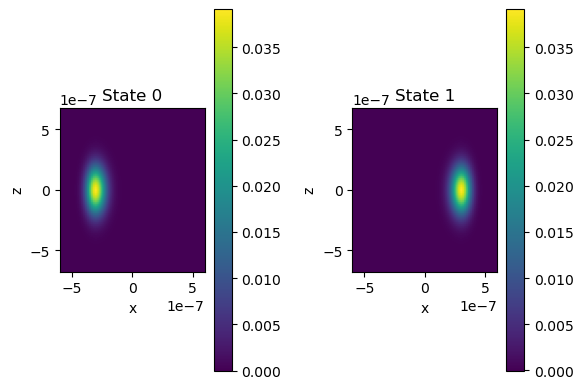

line: 330
separation: 1.4804 um


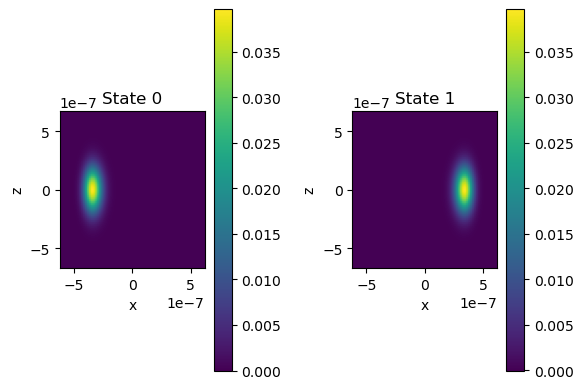

line: 331
separation: 1.4929 um


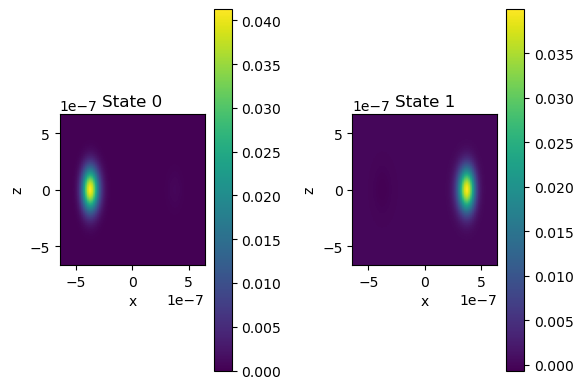

line: 332
separation: 1.5054 um


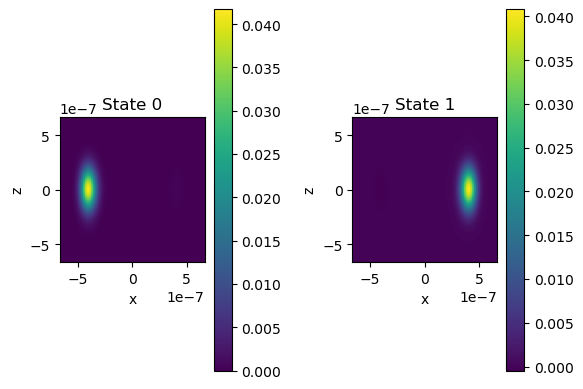

In [7]:
for i, line in enumerate(lines):
    state0 = state_nrs[i,0]
    state1 = state_nrs[i,1]
    
    trap, func_ham, res =  import_results(line)
    GS_left_1, GS_right_1 = get_localised_GS(res["states"][state0],
                                             res["states"][state1],
                                             degenerate=degeneracy[i])
    
    print(f"line: {line}")
    print(f"separation: {trap.subs(trap.distance_tweezers)/si.um:.4f} um")

    #plot wavefunctions
    n_states = 2

    states_plot = [GS_left_1.real, GS_right_1.real]
    #states_plot = [res["states"][state0].real, res["states"][state1].real]
    #states_plot = np.angle(states)
    #states_plot = states.imag
    #states_plot = np.abs(states)**2

    # Create a 1xn_states grid of subplots (1 row, n_states columns)
    fig, axes = plt.subplots(1, n_states, figsize=(6, 4))  # Adjust the size as needed

    # Loop over the state numbers from 0 to n_states-1
    for state_number, ax in zip(range(n_states), axes):
        # Slice through the y-direction and rotate the x-z plane (by swapping x and z)
        im = ax.imshow(states_plot[state_number][:, int(res["size"][1]/2), :].T,
                    extent=[*res["extend"][0], *res["extend"][2]], origin="lower",
                    vmin=np.min(states_plot[state_number]), vmax=np.max(states_plot[state_number]))

        # Set labels for each subplot
        ax.set_xlabel("x")
        ax.set_ylabel("z")
        ax.set_title(f"State {state_number}")
        fig.colorbar(im, ax=ax)  

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

In [8]:
frequencies = np.zeros_like(lines,dtype=float)
distance = np.zeros_like(lines,dtype=float)
J = np.zeros_like(lines,dtype=float)
#tilt = np.zeros_like(lines,dtype=float)
U_s = np.zeros_like(lines,dtype=float)
U_dds = np.zeros((len(lines),50),dtype=float)
angles = np.zeros((len(lines),50),dtype=float)
V_lrs = np.zeros((len(lines),50),dtype=float)
DeltaJs = np.zeros((len(lines),50),dtype=float)

E_exc = np.zeros_like(lines,dtype=float)
E_barr = np.zeros_like(lines,dtype=float)

for i, line in enumerate(lines):
    state0 = state_nrs[i,0]
    state1 = state_nrs[i,1]

    trap, func_ham, res =  import_results(line)
    GS_left_1, GS_right_1 = get_localised_GS(res["states"][state0],
                                             res["states"][state1],
                                             degenerate=degeneracy[i])
    
    frequencies[i] = float(trap.subs(sp.sqrt(2*trap.power_tweezer1*trap.a/sp.pi/trap.m) * 2/trap.waist_tweezer1**2))
    distance[i] = float(trap.subs(trap.distance_tweezers))
    J[i], U_s[i], U_dds[i], angles[i], V_lrs[i], DeltaJs[i] = analyse_diagonalisation(line,
                                                                state_nr0=state0,
                                                                state_nr1=state1,
                                                                degenerate=degeneracy[i],
                                                                n_angles=20)
    
    #estimate energies of 0th and 1st state
    E0 = 0.5*(res["energies"][0] + res["energies"][1])
    E1 = 0.5*(res["energies"][2] + res["energies"][3])
    E_exc[i] = E1-E0

    #estimate heigth of barrier
    V = trap.subs(trap.get_potential(apply_zero_offset=False))
    a = float(trap.subs(trap.distance_tweezers))

    #find minima of potential
    def V_func(x):
        return float(V.subs({trap.x:x, trap.y:0, trap.z:0}))

    x_right = minimize_scalar(V_func,bracket=[0,a]).x
    x_left = minimize_scalar(V_func,bracket=[-a,0]).x

    #catch case where both potentials have already merged
    tunneling_dist = abs(x_right-x_left)
    if tunneling_dist < 1e-15:
        raise Exception("potential has only one minmum")

    #depts of both tweezers
    V_1 = abs(V_func(x_left) - V_func(0))
    V_2 = abs(V_func(x_right) - V_func(0)) 

    E_barr[i] = np.max([V_1,V_2])

    # these states are basically 1 tweezer
    if state1 !=1:
        J[i] = np.nan
        U_s[i] = np.nan
        U_dds[i] = np.nan
        V_lrs[i] = np.nan
        DeltaJs[i] = np.nan
        E_exc[i] = np.nan
        E_barr[i] = np.nan


----------------------

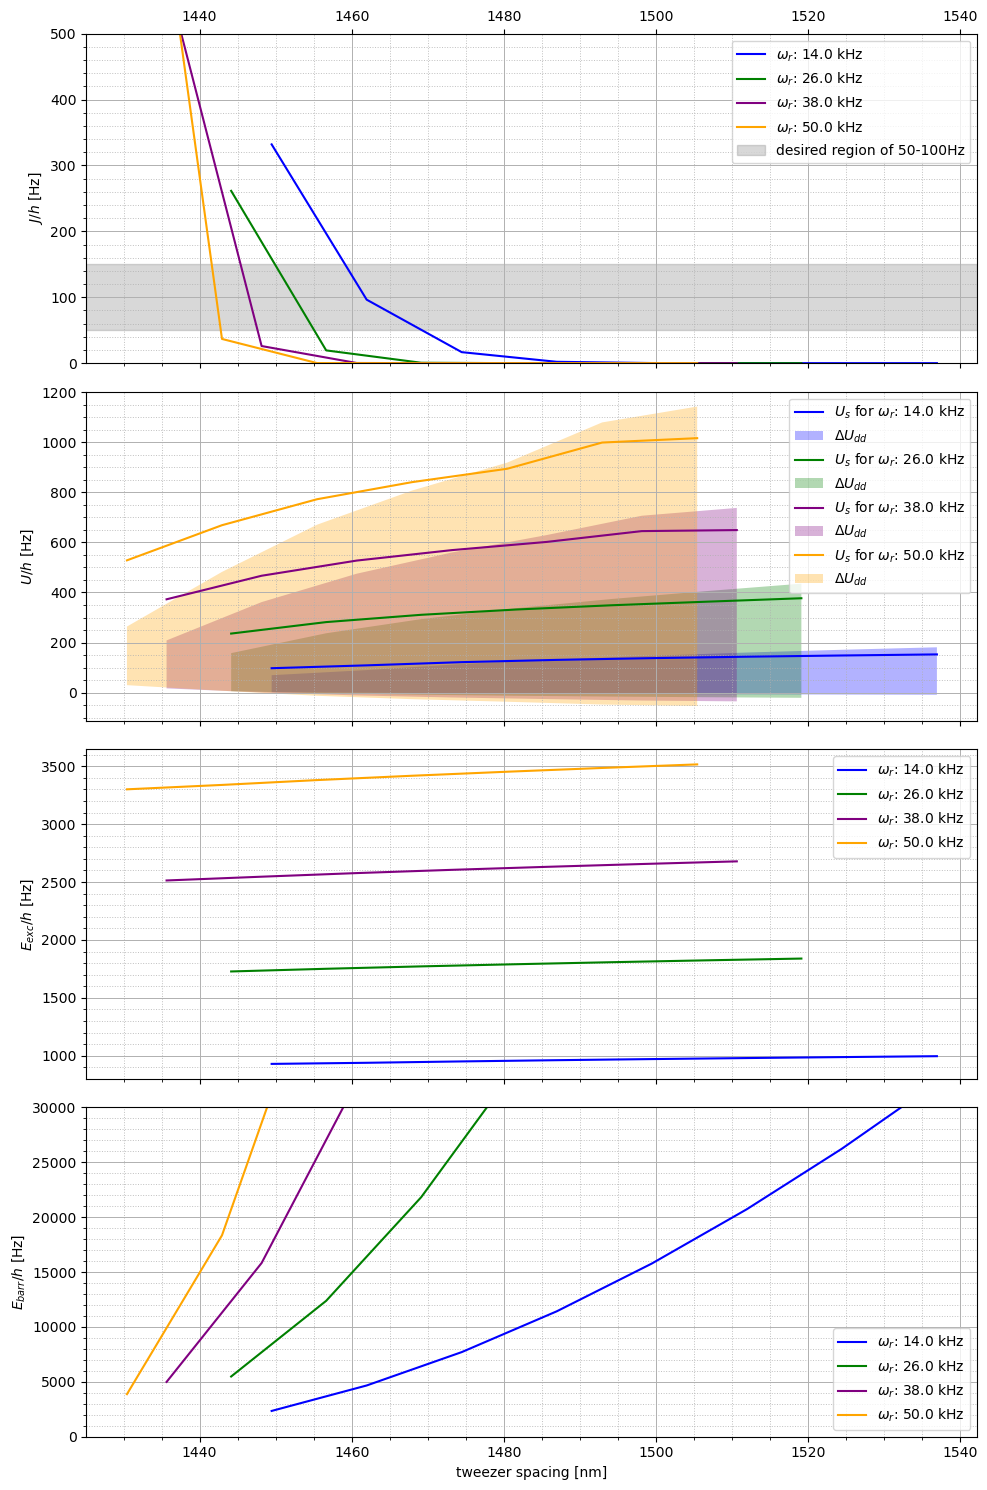

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with 4 subplots (stacked vertically)
fig, axes = plt.subplots(4, 1, figsize=(10, 15), sharex=True)

# Get unique frequencies
unique_freqs = np.unique(frequencies)[1:]

# Define colors for consistency
colors = ["red", "blue", "green", "purple", "orange"][1:]

### 1️⃣ Hopping parameter J ###
for i, (freq, color) in enumerate(zip(unique_freqs, colors)):
    mask = frequencies == freq
    axes[0].plot(distance[mask] / si.nm, J[mask] / const.h, color=color, 
                 label=fr"$\omega_r$: {freq/2/np.pi/si.kHz:.1f} kHz")

axes[0].axhspan(50, 150, alpha=0.3, color="gray", label="desired region of 50-100Hz")
axes[0].set_ylim(0,500)
axes[0].set_ylabel(r"$J/h$ [Hz]")
axes[0].legend()
# 🔹 Add top x-axis ticks
axes[0].tick_params(axis="x", labeltop=True, top=True)
axes[0].grid(True, linestyle='-', linewidth=0.7)
axes[0].minorticks_on()
axes[0].grid(True, which='minor', linestyle=':', linewidth=0.7, alpha=0.8)

### 2️⃣ Interaction parameter U ###
for i, (freq, color) in enumerate(zip(unique_freqs, colors)):
    mask = frequencies == freq
    x = distance[mask] / si.nm
    y = U_s[mask] / const.h
    delta = U_dds[mask] / const.h

    axes[1].plot(x, y, color=color, label=fr"$U_s$ for $\omega_r$: {freq/2/np.pi/si.kHz:.1f} kHz")
    axes[1].fill_between(x, y + np.min(delta, axis=1), y + np.max(delta, axis=1), 
                         alpha=0.3, color=color, edgecolor=None, label=r"$\Delta U_{dd}$")

axes[1].set_ylabel(r"$U/h$ [Hz]")
axes[1].legend()
axes[1].grid(True, linestyle='-', linewidth=0.7)
axes[1].minorticks_on()
axes[1].grid(True, which='minor', linestyle=':', linewidth=0.7, alpha=0.8)

### 3️⃣ First excited state energy ###
for i, (freq, color) in enumerate(zip(unique_freqs, colors)):
    mask = frequencies == freq
    axes[2].plot(distance[mask] / si.nm, E_exc[mask] / const.h, color=color, 
                 label=fr"$\omega_r$: {freq/2/np.pi/si.kHz:.1f} kHz")

axes[2].set_ylabel(r"$E_{exc}/h$ [Hz]")
axes[2].legend()
axes[2].grid(True, linestyle='-', linewidth=0.7)
axes[2].minorticks_on()
axes[2].grid(True, which='minor', linestyle=':', linewidth=0.7, alpha=0.8)

### 4️⃣ Barrier height ###
for i, (freq, color) in enumerate(zip(unique_freqs, colors)):
    mask = frequencies == freq
    axes[3].plot(distance[mask] / si.nm, E_barr[mask] / const.h, color=color, 
                 label=fr"$\omega_r$: {freq/2/np.pi/si.kHz:.1f} kHz")

axes[3].set_ylabel(r"$E_{barr}/h$ [Hz]")
axes[3].set_xlabel("tweezer spacing [nm]")
axes[3].set_ylim(0, 30000)
axes[3].legend()
axes[3].grid(True, linestyle='-', linewidth=0.7)
axes[3].minorticks_on()
axes[3].grid(True, which='minor', linestyle=':', linewidth=0.7, alpha=0.8)

# Improve layout
plt.tight_layout()
plt.show()


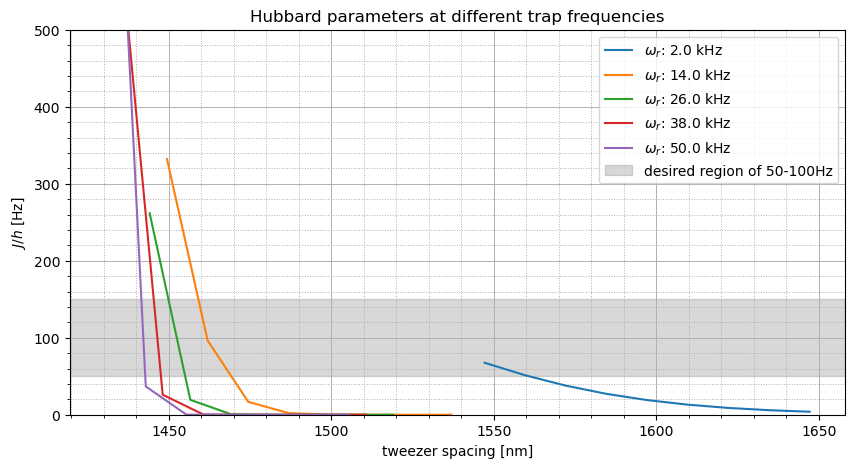

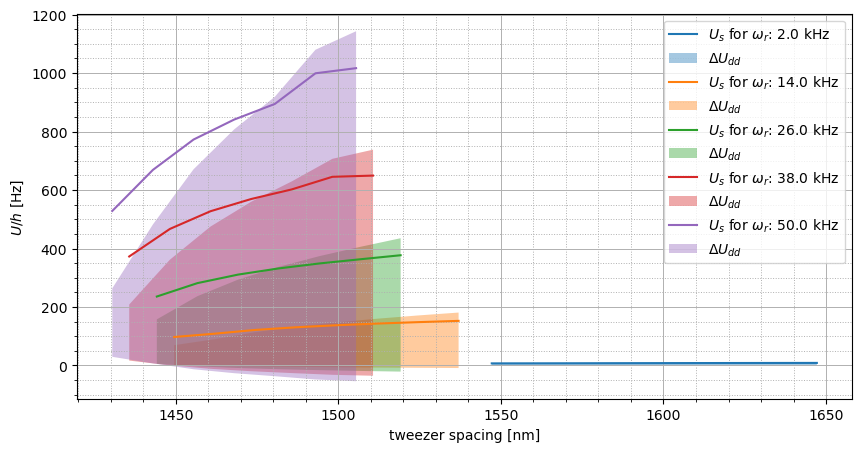

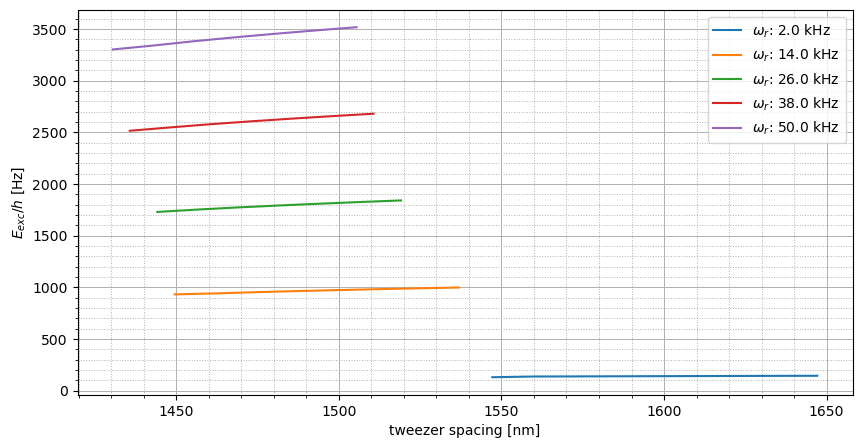

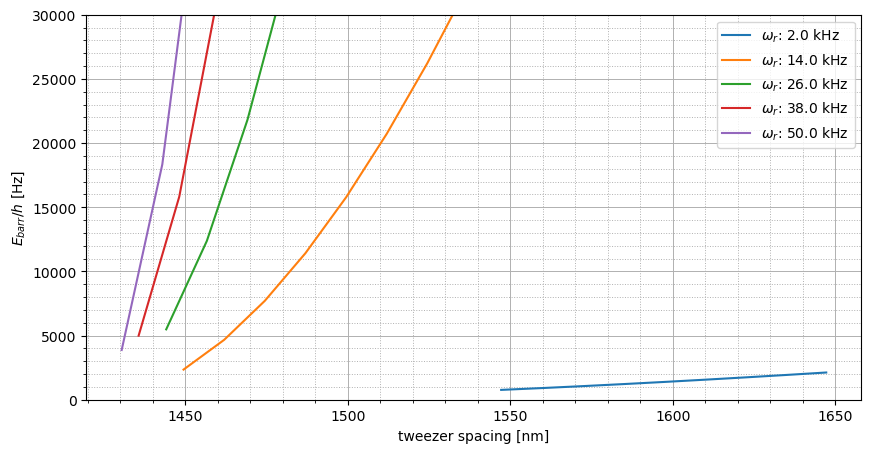

In [10]:
#hopping
plt.figure(figsize=(10,5))
for i, freq in enumerate(np.unique(frequencies)):
    plt.plot(distance[frequencies == freq]/si.nm, J[frequencies == freq]/const.h,
             label=fr"$\omega_r$: {freq/2/np.pi/si.kHz:.1f} kHz")

#plt.axhline(100,linestyle='dashed',color="black",label="J=100Hz")
plt.axhspan(50,150,alpha=0.3, color="gray",label="desired region of 50-100Hz")

plt.ylim(0,500)
plt.title("Hubbard parameters at different trap frequencies")
plt.xlabel("tweezer spacing [nm]")
plt.ylabel(r"$J/h$ [Hz]")
plt.legend()
plt.grid(True, linestyle='-', linewidth=0.7)
# Minor grid (finer)
plt.minorticks_on()
plt.grid(True, which='minor', linestyle=':', linewidth=0.7, alpha=1)
plt.show()


#interactions
plt.figure(figsize=(10,5))
for i, freq in enumerate(np.unique(frequencies)):
    mask = frequencies == freq
    x = distance[mask] / si.nm
    y = U_s[mask] / const.h
    delta = U_dds[mask] / const.h

    # Plot U_s curve
    plt.plot(x, y, label=fr"$U_s$ for $\omega_r$: {freq/2/np.pi/si.kHz:.1f} kHz")

    # Shade around the curve due to dipolar interactions
    plt.fill_between(x, y + np.min(delta,axis=1), y + np.max(delta,axis=1),
                     alpha=0.4, label=r"$\Delta U_{dd}$")

plt.xlabel("tweezer spacing [nm]")
plt.ylabel(r"$U/h$ [Hz]")
plt.legend()
plt.grid(True, linestyle='-', linewidth=0.7)
# Minor grid (finer)
plt.minorticks_on()
plt.grid(True, which='minor', linestyle=':', linewidth=0.7, alpha=1)
plt.show()


#first excited state
plt.figure(figsize=(10,5))
for i, freq in enumerate(np.unique(frequencies)):
    plt.plot(distance[frequencies == freq]/si.nm, E_exc[frequencies == freq]/const.h,
             label=fr"$\omega_r$: {freq/2/np.pi/si.kHz:.1f} kHz")
    


plt.xlabel("tweezer spacing [nm]")
plt.ylabel(r"$E_{exc}/h$ [Hz]")
plt.legend()
plt.grid(True, linestyle='-', linewidth=0.7)
# Minor grid (finer)
plt.minorticks_on()
plt.grid(True, which='minor', linestyle=':', linewidth=0.7, alpha=1)
plt.show()


#height of barrier
plt.figure(figsize=(10,5))
for i, freq in enumerate(np.unique(frequencies)):
    plt.plot(distance[frequencies == freq]/si.nm, E_barr[frequencies == freq]/const.h,
             label=fr"$\omega_r$: {freq/2/np.pi/si.kHz:.1f} kHz")

plt.ylim(0,30000)
plt.xlabel("tweezer spacing [nm]")
plt.ylabel(r"$E_{barr}/h$ [Hz]")
plt.legend()
plt.grid(True, linestyle='-', linewidth=0.7)
# Minor grid (finer)
plt.minorticks_on()
plt.grid(True, which='minor', linestyle=':', linewidth=0.7, alpha=1)
plt.show()